In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score, classification_report

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader , TensorDataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

import joblib

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
path_to_py = os.path.abspath('../src')
print(path_to_py)

/Users/gedelasnigda/loan_default/src


In [115]:
# Importing cleaned data
loan_df = pd.read_csv(os.path.join(path_to_py,"data","cleaned_data.csv"))
loan_df.head()

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,percent_bc_gt_75,bc_util,dti,...,mths_since_recent_inq,revol_util,total_bc_limit,mths_since_last_major_derog,tot_hi_cred_lim,tot_cur_bal,internal_score,bad_flag,active_acc,lti
0,7550,36.0,16.24,3.0,RENT,28000.0,debt_consolidation,100.0,96.0,8.40,...,17.0,72.0,4000.0,999.0,3828.953801,5759.0,99,0.0,1,0.269643
1,27050,36.0,10.99,10.0,OWN,55000.0,debt_consolidation,25.0,53.9,22.87,...,8.0,61.2,35700.0,999.0,34359.940730,114834.0,353,0.0,1,0.491818
2,12000,36.0,10.99,4.0,RENT,60000.0,debt_consolidation,0.0,15.9,4.62,...,3.0,24.0,18100.0,999.0,16416.617760,7137.0,157,0.0,1,0.200000
3,28000,36.0,7.62,5.0,MORTGAGE,325000.0,debt_consolidation,16.7,67.1,18.55,...,3.0,54.6,42200.0,999.0,38014.149760,799592.0,365,0.0,1,0.086154
4,12000,36.0,13.53,10.0,RENT,40000.0,debt_consolidation,33.3,79.6,16.94,...,17.0,68.8,7000.0,53.0,6471.462236,13605.0,157,0.0,1,0.300000


In [25]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189457 entries, 0 to 189456
Data columns (total 21 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    189457 non-null  int64  
 1   term                         189457 non-null  float64
 2   int_rate                     189457 non-null  float64
 3   emp_length                   189457 non-null  float64
 4   home_ownership               189457 non-null  object 
 5   annual_inc                   189457 non-null  float64
 6   purpose                      189457 non-null  object 
 7   percent_bc_gt_75             189457 non-null  float64
 8   bc_util                      189457 non-null  float64
 9   dti                          189457 non-null  float64
 10  inq_last_6mths               189457 non-null  float64
 11  mths_since_recent_inq        189457 non-null  float64
 12  revol_util                   189457 non-null  float64
 13 

## Feature Selection

- With only 21 features, the dimensionality is manageable, so the ANN can efficiently learn relevant patterns even without explicit feature selection.
- With 189,456 rows, the dataset is large enough to handle many features without the risk of overfitting, provided the model architecture is well-designed.
- ANNs are capable of learning hierarchical representations and may inherently identify and ignore irrelevant features during training.

**Approach I am following:**
- Drop few features that we founf to be clearly highly correlated with each other to avoid multicollinearity.
- Train ANN with all features, use regularization techniques and evaluate its performance.
- Analyze Feature Importance to identify less relevant features after training.
- Prune If Necessary if redundant or irrelevant features found.
- Retrain the model with a reduced feature set and compare performance metrics.

### Drop features to reduce multicolinearity

1. **'bc_util' and 'percent_bc_gt_75' (correlation: 0.84):**
     - Retain 'bc_util' because it provides a more granular measure of utilization and is a continuous variable.

2. **'bc_util' and 'revol_util' (correlation: 0.72):**
     - Retain both initially, as they represent slightly different credit utilization perspectives. 
     - If necessary, evaluate their importance during feature importance analysis.

3. **'total_bc_limit' and 'tot_hi_cred_lim' (correlation: 1.00):**
     - Retain 'tot_hi_cred_lim', as it represents a more comprehensive measure of high credit limits across all accounts.

In [116]:
# Dropping 'percent_bc_gt_75' and 'total_bc_limit'
loan_df.drop(['percent_bc_gt_75' , 'total_bc_limit'],axis=1,inplace=True)

In [183]:
loan_df.columns

Index(['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
       'annual_inc', 'purpose', 'bc_util', 'dti', 'inq_last_6mths',
       'mths_since_recent_inq', 'revol_util', 'mths_since_last_major_derog',
       'tot_hi_cred_lim', 'tot_cur_bal', 'internal_score', 'bad_flag',
       'active_acc', 'lti'],
      dtype='object')

### Data Preprocessing

- **Scaling the Data:** Scaling is essential for Artificial Neural Networks (ANNs) because the optimization algorithms, such as gradient descent, perform better when features are on a similar scale. If features have vastly different ranges, the model may converge slowly or get stuck in suboptimal solutions due to uneven weight updates. Standardizing numerical data ensures that all input features contribute equally to the learning process.

- **One-Hot Encoding:** This process ensures that the ANN treats categorical features as distinct entities without assuming an ordinal relationship between them.

- **Over-Sampling with SMOTE:**  The dataset is highly imbalanced, with one class significantly outnumbering the others. To address this, SMOTE generates synthetic samples for the minority class by interpolating between existing samples, creating a more balanced dataset.

In [118]:
# Function to preprocess the data (One-hot encoding, Scaling)
def preprocess_data(df, target, categorical_features, numerical_features, is_train=True, fitted_preprocessor=None):
    """
    Preprocesses data by handling categorical variables (one-hot encoding),
    numerical variables (scaling), and returns transformed data.

    """
    y = df[target]
    X = df.drop(columns=[target])
    
    
    if is_train:
        # Define transformers for preprocessing
        
        numerical_transformer = Pipeline(steps=[
            ('scaler', StandardScaler())  # Scale numerical data
        ])
   
        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
        ])
    
        # Column transformer combining both
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_features),
                ('cat', categorical_transformer, categorical_features)
            ]
        )
    
        # Fit the preprocessor on training data
        X_transformed = preprocessor.fit_transform(X)
    
    else:
        # Use the pre-fitted preprocessor for test data
        X_transformed = fitted_preprocessor.transform(X)
        preprocessor = fitted_preprocessor

    return X_transformed, y, preprocessor

# Function to apply SMOTE for oversampling
def apply_smote(X, y):
    """
    Applies SMOTE to handle class imbalance.
    
    """
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)

    return X_resampled, y_resampled

# Main function to split data, preprocess, and handle oversampling
def prepare_data(df, target, categorical_features, numerical_features):
    """
    Splits the data into training, validation, and testing sets, preprocesses it, 
    and applies SMOTE for oversampling.
    
    """
    # Split data into training (60%), validation (20%), and testing (20%) sets
    train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df[target], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[target], random_state=42)
 
    # Preprocess training data
    X_train, y_train, preprocessor = preprocess_data(train_df, target, categorical_features, numerical_features, is_train=True)
    
    # Apply SMOTE for training data
    X_train_resampled, y_train_resampled = apply_smote(X_train, y_train)
    
    # Preprocess validation and test data using the fitted preprocessor
    X_val, y_val, _ = preprocess_data(val_df, target, categorical_features, numerical_features, is_train=False, fitted_preprocessor=preprocessor)
    X_test, y_test, _ = preprocess_data(test_df, target, categorical_features, numerical_features, is_train=False, fitted_preprocessor=preprocessor)

    return X_train_resampled, X_val, X_test, y_train_resampled, y_val, y_test, preprocessor


In [147]:
# Extract categorical features (object or category types)
categorical_features = loan_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Extract numerical features (int64 or float64 types)
numerical_features = loan_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features.remove('active_acc')
numerical_features.remove('bad_flag')

target = 'bad_flag'

# Prepare the data for model building
X_train_resampled, X_val, X_test, y_train_resampled, y_val, y_test, fitted_preprocessor = prepare_data(loan_df, target, categorical_features, numerical_features)


In [105]:
# Check if the over-sampling has been done
y_train_resampled.value_counts()

bad_flag
0.0    105797
1.0    105797
Name: count, dtype: int64

In [106]:
# Print the shapes of the resulting datasets
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)

print("\nX_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("\nX_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train_resampled shape: (211594, 33)
y_train_resampled shape: (211594,)

X_val shape: (37891, 33)
y_val shape: (37891,)

X_test shape: (37892, 33)
y_test shape: (37892,)


## Model Building
### Model 1

In [107]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [109]:
# Evaluation function for classification report and confusion matrix
def evaluate_model(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, preds = torch.max(outputs, 1)

    # Evaluation metrics
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, preds))
    
    print("\nClassification Report:")
    print(classification_report(y, preds))

In [108]:
# Define the Neural Network Model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)  # First hidden layer with 128 units
        self.fc2 = nn.Linear(128, 64)         # Second hidden layer with 64 units
        self.fc3 = nn.Linear(64, 32)          # Third hidden layer with 32 units
        self.fc4 = nn.Linear(32, 2)           # Output layer with 2 units (for binary classification)

        self.relu = nn.ReLU()                 # Activation function
        self.softmax = nn.Softmax(dim=1)      # Softmax for binary classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return self.softmax(x)
    

# Initialize the model
input_dim = X_train_resampled.shape[1]  # Number of features
model = SimpleNN(input_dim)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 20  # Number of epochs

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)   # Forward pass
        loss = criterion(output, target)  # Compute the loss
        loss.backward()        # Backpropagation
        optimizer.step()       # Update the weights

        running_loss += loss.item()

    # Print loss every epoch
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_preds = []
    val_labels = []
    with torch.no_grad():  # No need to track gradients during validation
        for data, target in val_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            val_preds.extend(predicted.numpy())
            val_labels.extend(target.numpy())

    # Compute validation accuracy
    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the validation data
evaluate_model(model, X_train_tensor, y_train_tensor)

# Evaluate the model on the validation data
evaluate_model(model, X_val_tensor, y_val_tensor)

Epoch 1/20, Loss: 0.6199323517482447
Validation Accuracy: 0.6104
Epoch 2/20, Loss: 0.5861742713586924
Validation Accuracy: 0.6147
Epoch 3/20, Loss: 0.5586558373215194
Validation Accuracy: 0.7423
Epoch 4/20, Loss: 0.5413559216691678
Validation Accuracy: 0.6879
Epoch 5/20, Loss: 0.5297309431129977
Validation Accuracy: 0.7900
Epoch 6/20, Loss: 0.5206217712908308
Validation Accuracy: 0.7299
Epoch 7/20, Loss: 0.5143563224716348
Validation Accuracy: 0.7265
Epoch 8/20, Loss: 0.5083285308799824
Validation Accuracy: 0.7332
Epoch 9/20, Loss: 0.5022904702569554
Validation Accuracy: 0.7222
Epoch 10/20, Loss: 0.4977322107432723
Validation Accuracy: 0.8047
Epoch 11/20, Loss: 0.49411196982820915
Validation Accuracy: 0.7667
Epoch 12/20, Loss: 0.49032549923699825
Validation Accuracy: 0.7564
Epoch 13/20, Loss: 0.4863485916074684
Validation Accuracy: 0.8053
Epoch 14/20, Loss: 0.4838323323593999
Validation Accuracy: 0.7692
Epoch 15/20, Loss: 0.48072499032282995
Validation Accuracy: 0.7777
Epoch 16/20, Los

- The model is clearly overfitting, especially for the class label 1. Let's add more dropout layers to reduce overfitting.

### Model 2

In [110]:
# Define the neural network model
class LoanPredictionNN(nn.Module):
    def __init__(self, input_dim):
        super(LoanPredictionNN, self).__init__()
        # A more simplified model with dropout and regularization
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(0.5)  # Dropout with 50% probability
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)  # Dropout with 50% probability
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 2)  # Binary classification output
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return self.softmax(x)


# Training function
def train_model(model, train_loader, val_loader, epochs=20, lr=0.001):
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()  # For binary classification
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track best model and loss
    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 5  # Early stopping after 5 epochs with no improvement

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        
        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model

train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# Initialize model
input_dim = X_train_resampled.shape[1]  # Number of features
model = LoanPredictionNN(input_dim)

# Train the model with early stopping and dropout
trained_model = train_model(model, train_loader, val_loader)

# Evaluate the model on the validation data
evaluate_model(trained_model, X_train_tensor, y_train_tensor)

# Evaluate the model on the validation data
evaluate_model(trained_model, X_val_tensor, y_val_tensor)

Epoch 1/20, Loss: 0.6311, Validation Loss: 0.6302, Validation Accuracy: 0.6158
Epoch 2/20, Loss: 0.6180, Validation Loss: 0.6510, Validation Accuracy: 0.5466
Epoch 3/20, Loss: 0.6100, Validation Loss: 0.6112, Validation Accuracy: 0.6471
Epoch 4/20, Loss: 0.6025, Validation Loss: 0.6160, Validation Accuracy: 0.6444
Epoch 5/20, Loss: 0.5953, Validation Loss: 0.5893, Validation Accuracy: 0.6545
Epoch 6/20, Loss: 0.5903, Validation Loss: 0.5924, Validation Accuracy: 0.6720
Epoch 7/20, Loss: 0.5858, Validation Loss: 0.5576, Validation Accuracy: 0.7169
Epoch 8/20, Loss: 0.5824, Validation Loss: 0.5778, Validation Accuracy: 0.6763
Epoch 9/20, Loss: 0.5790, Validation Loss: 0.5631, Validation Accuracy: 0.6966
Epoch 10/20, Loss: 0.5761, Validation Loss: 0.5784, Validation Accuracy: 0.6761
Epoch 11/20, Loss: 0.5738, Validation Loss: 0.5575, Validation Accuracy: 0.7156
Epoch 12/20, Loss: 0.5723, Validation Loss: 0.5759, Validation Accuracy: 0.6924
Epoch 13/20, Loss: 0.5701, Validation Loss: 0.568

### Model 3

In [100]:
# Define the neural network model
class LoanPredictionNN(nn.Module):
    def __init__(self, input_dim):
        super(LoanPredictionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 25)
        self.batch_norm1 = nn.BatchNorm1d(25)
        self.fc2 = nn.Linear(25, 55)
        self.batch_norm2 = nn.BatchNorm1d(55)
        self.fc3 = nn.Linear(55, 35)
        self.batch_norm3 = nn.BatchNorm1d(35)
        self.fc4 = nn.Linear(35, 25)
        self.batch_norm4 = nn.BatchNorm1d(25)
        self.output_layer = nn.Linear(25, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.batch_norm1(self.fc1(x)))
        x = torch.relu(self.batch_norm2(self.fc2(x)))
        x = torch.relu(self.batch_norm3(self.fc3(x)))
        x = torch.relu(self.batch_norm4(self.fc4(x)))
        x = self.sigmoid(self.output_layer(x))
        return x


# Training function
def train_model(model, train_loader, val_loader, epochs=40, lr=0.001, weight_decay=0.001):
    # Loss and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Track best model and loss
    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 5  # Early stopping after 5 epochs with no improvement

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        
        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
        
        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model

# Initialize model
input_dim = X_train_tensor.shape[1]  # Number of features
model = LoanPredictionNN(input_dim)

# Train the model with early stopping and regularization
trained_model = train_model(model, train_loader, val_loader)

# Evaluate the model on the training data
evaluate_model(trained_model, X_train_tensor, y_train_tensor)

# Evaluate the model on the validation data
evaluate_model(trained_model, X_val_tensor, y_val_tensor)


Epoch 1/40, Loss: 0.6174, Validation Loss: 0.6492, Validation Accuracy: 0.5646
Epoch 2/40, Loss: 0.5918, Validation Loss: 0.5653, Validation Accuracy: 0.6554
Epoch 3/40, Loss: 0.5691, Validation Loss: 0.5264, Validation Accuracy: 0.7127
Epoch 4/40, Loss: 0.5615, Validation Loss: 0.5448, Validation Accuracy: 0.6936
Epoch 5/40, Loss: 0.5565, Validation Loss: 0.5962, Validation Accuracy: 0.6334
Epoch 6/40, Loss: 0.5514, Validation Loss: 0.5382, Validation Accuracy: 0.6928
Epoch 7/40, Loss: 0.5487, Validation Loss: 0.5562, Validation Accuracy: 0.6869
Epoch 8/40, Loss: 0.5452, Validation Loss: 0.5621, Validation Accuracy: 0.6689
Early stopping at epoch 8

Confusion Matrix:
[[72014 33783]
 [25813 79984]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71    105797
         1.0       0.70      0.76      0.73    105797

    accuracy                           0.72    211594
   macro avg       0.72      0.72      0.72    211

## Weights...
- The overfitting still retains in the above models.
- let us try to use /...weights..... idea instead of SMOTE to handle data imbalance.

### Preporcessing the data
- Scaling
- One Hot Encoding
- The earlier preprocessing involves SMOTE, so reoding it in order to perform scaling and one hot encoding only.

In [113]:
# Function preprocess_data defined created above

# Main function to split data, preprocess, and handle oversampling
def prepare_data_method(df, target, categorical_features, numerical_features):
    """
    Splits the data into training, validation, and testing sets and preprocesses it.
    """
    # Split data into training (60%), validation (20%), and testing (20%) sets
    train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df[target], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[target], random_state=42)
 
    # Preprocess training data
    X_train, y_train, preprocessor = preprocess_data(train_df, target, categorical_features, numerical_features, is_train=True)
    
    # Preprocess validation and test data using the fitted preprocessor
    X_val, y_val, _ = preprocess_data(val_df, target, categorical_features, numerical_features, is_train=False, fitted_preprocessor=preprocessor)
    X_test, y_test, _ = preprocess_data(test_df, target, categorical_features, numerical_features, is_train=False, fitted_preprocessor=preprocessor)

    return X_train, X_val, X_test, y_train, y_val, y_test, preprocessor

In [127]:

# Prepare the data for model building
X_train, X_val, X_test, y_train, y_val, y_test, fitted_preprocessor = prepare_data(loan_df, target, categorical_features, numerical_features)

In [128]:
# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("\nX_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("\nX_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (113674, 33)
y_train shape: (113674,)

X_val shape: (37891, 33)
y_val shape: (37891,)

X_test shape: (37892, 33)
y_test shape: (37892,)


In [129]:
y_train.value_counts()

bad_flag
0.0    105797
1.0      7877
Name: count, dtype: int64

### Final model: Computing class weights to handle data imbalance

In [123]:
# Calculate class weights using sklearn's 'balanced' method
classes = np.array([0, 1])  # Specify the unique class labels
class_weights = compute_class_weight( class_weight='balanced', classes=classes, y=loan_df['bad_flag'])

# Convert class weights to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Print results
print("\nClass weights tensor:")
print(class_weights_tensor)


Class weights tensor:
tensor([0.5372, 7.2158])


In [132]:
# Print the shapes of the resulting datasets
print("X_train type:", type(X_train))
print("y_train type:", type(y_train))

print("\nX_val type:", type(X_val))
print("y_val type:", type(y_val))

print("\nX_test type:", type(X_test))
print("y_test type:", type(y_test))

X_train type: <class 'numpy.ndarray'>
y_train type: <class 'pandas.core.series.Series'>

X_val type: <class 'numpy.ndarray'>
y_val type: <class 'pandas.core.series.Series'>

X_test type: <class 'numpy.ndarray'>
y_test type: <class 'pandas.core.series.Series'>


In [135]:
# Create PyTorch Dataset class
class LoanDataset(Dataset):
   def __init__(self, X, y):
       self.X = torch.FloatTensor(X)
       self.y = torch.FloatTensor(y)
   
   def __len__(self):
       return len(self.y)
   
   def __getitem__(self, idx):
       return self.X[idx], self.y[idx]

# Convert y splits from Pandas Series to NumPy arrays
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

batch_size = 256  

# Create DataLoaders
train_loader = DataLoader( LoanDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
val_loader = DataLoader( LoanDataset(X_val, y_val), batch_size=batch_size, shuffle=False)
test_loader = DataLoader( LoanDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

In [144]:
class LoanDefaultModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super(LoanDefaultModel, self).__init__()
        
        # Input Layer with Batch Normalization
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        # Create layers dynamically
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output Layer
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        
    def forward(self, x):
        # Input normalization
        x = self.input_bn(x)
        
        # Hidden layers
        x = self.hidden_layers(x)
        
        # Output layer with sigmoid activation
        return torch.sigmoid(self.output_layer(x))

# Initialize model
input_dim = 33  # number of features
model = LoanDefaultModel(input_dim)


In [168]:
# 1. Set up training components

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Custom Weighted BCE Loss
class WeightedBCELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = weights

    def forward(self, output, target):
        # Calculate BCE loss
        loss = -self.weights[1] * target * torch.log(output + 1e-7) - \
               self.weights[0] * (1 - target) * torch.log(1 - output + 1e-7)
        return torch.mean(loss)
    
# Initialize loss function with class weights
class_weights = torch.FloatTensor([0.5372, 7.2154]).to(device)
criterion = WeightedBCELoss(class_weights)

# Optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='max',      # monitor validation AUROC
    factor=0.5,      # reduce LR by half when plateauing
    patience=3,      # number of epochs to wait before reducing LR
)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_auroc = None
        self.early_stop = False
        
    def __call__(self, val_auroc):
        if self.best_auroc is None:
            self.best_auroc = val_auroc
        elif val_auroc <= self.best_auroc + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_auroc = val_auroc
            self.counter = 0

# Modify training and validation functions to use device
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    predictions = []
    targets = []
    
    for batch_X, batch_y in train_loader:
        # Move batch to device
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend(outputs.cpu().detach().numpy())
        targets.extend(batch_y.cpu().numpy())
    
    # # Calculate metrics
    # auroc = roc_auc_score(targets, predictions)
    # avg_precision = average_precision_score(targets, predictions)
    
    # return total_loss / len(train_loader), auroc, avg_precision

    # Calculate all metrics
    predictions = np.array(predictions)
    targets = np.array(targets)
    binary_preds = (predictions >= 0.5).astype(int)
    
    metrics = {
        'loss': total_loss / len(train_loader),
        'auroc': roc_auc_score(targets, predictions),
        'avg_precision': average_precision_score(targets, predictions),
        'f1': f1_score(targets, binary_preds),
        'classification_report': classification_report(targets, binary_preds)
    }
    
    return metrics

def validate(model, val_loader):
    model.eval()
    total_loss = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            # Move batch to device
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    
    # # Calculate metrics
    # auroc = roc_auc_score(targets, predictions)
    # avg_precision = average_precision_score(targets, predictions)
    
    # return total_loss / len(val_loader), auroc, avg_precision
    # Calculate all metrics
    predictions = np.array(predictions)
    targets = np.array(targets)
    binary_preds = (predictions >= 0.5).astype(int)
    
    metrics = {
        'loss': total_loss / len(val_loader),
        'auroc': roc_auc_score(targets, predictions),
        'avg_precision': average_precision_score(targets, predictions),
        'f1': f1_score(targets, binary_preds),
        'classification_report': classification_report(targets, binary_preds)
    }
    
    return metrics

# Training configuration
n_epochs = 100
early_stopping = EarlyStopping(patience=5)

best_val_auroc = 0
best_model_state = None
early_stopping = EarlyStopping(patience=5)

# Lists to store metrics
train_metrics_history = []
val_metrics_history = []

print("Epoch\tTrain Loss\tTrain AUROC\tTrain F1\tVal Loss\tVal AUROC\tVal F1")

for epoch in range(n_epochs):
    # Training phase
    train_metrics = train_epoch(model, train_loader, criterion, optimizer)
    
    # Validation phase
    val_metrics = validate(model, val_loader)
    
    # Store metrics
    train_metrics_history.append(train_metrics)
    val_metrics_history.append(val_metrics)
    
    # Print metrics
    print(f"{epoch+1}\t{train_metrics['loss']:.4f}\t\t{train_metrics['auroc']:.4f}\t\t"
      f"{train_metrics['f1']:.4f}\t\t"
      f"{val_metrics['loss']:.4f}\t\t{val_metrics['auroc']:.4f}\t\t"
      f"{val_metrics['f1']:.4f}")

    
    # Print classification report every 5 epochs
    '''if (epoch + 1) % 5 == 0:
        print("\nValidation Classification Report:")
        print(val_metrics['classification_report'])'''
    
    # Learning rate scheduling
    scheduler.step(val_metrics['auroc'])
    
    # Early stopping
    early_stopping(val_metrics['auroc'])
    
    # Save best model
    if val_metrics['auroc'] > best_val_auroc:
        best_val_auroc = val_metrics['auroc']
        best_model_state = model.state_dict().copy()
        ''' print(f"\nNew best model saved with validation AUROC: {best_val_auroc:.4f}")
        print("Classification Report for Best Model:")
        print(val_metrics['classification_report'])'''
    
    if early_stopping.early_stop:
        print("\nTrain Classification Report:")
        print(train_metrics['classification_report'])
        print("\nValidation Classification Report:")
        print(val_metrics['classification_report'])
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)

Using device: cpu
Epoch	Train Loss	Train AUROC	Train F1	Val Loss	Val AUROC	Val F1
1	0.6047		0.7300		0.2069		0.6376		0.6948		0.1955
2	0.6052		0.7299		0.2059		0.6375		0.6966		0.1952
3	0.6041		0.7320		0.2069		0.6413		0.6976		0.1958
4	0.6063		0.7301		0.2063		0.6388		0.6991		0.1991
5	0.6040		0.7313		0.2060		0.6455		0.6961		0.1946
6	0.6109		0.7310		0.2064		0.6409		0.6953		0.1951
7	0.6045		0.7313		0.2069		0.6415		0.6949		0.1948
8	0.6029		0.7326		0.2076		0.6511		0.6959		0.1933
9	0.6032		0.7325		0.2075		0.6403		0.6956		0.1940

Train Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.59      0.73    105797
         1.0       0.12      0.75      0.21      7877

    accuracy                           0.60    113674
   macro avg       0.55      0.67      0.47    113674
weighted avg       0.91      0.60      0.70    113674


Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0

<All keys matched successfully>

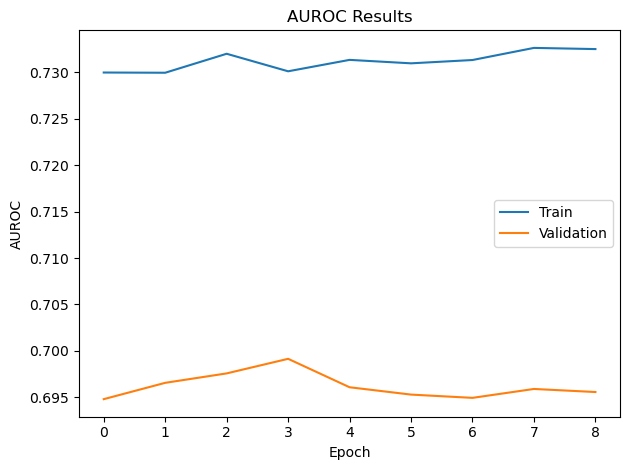

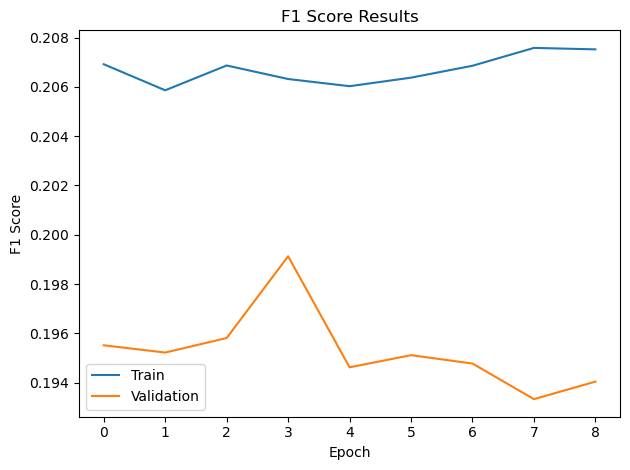

In [169]:
# AUROC plot
plt.plot([m['auroc'] for m in train_metrics_history], label='Train')
plt.plot([m['auroc'] for m in val_metrics_history], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('AUROC')
plt.legend()
plt.title('AUROC Results')
plt.tight_layout()
plt.show()

# F1 Score plot
plt.plot([m['f1'] for m in train_metrics_history], label='Train')
plt.plot([m['f1'] for m in val_metrics_history], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score Results')
plt.tight_layout()
plt.show()

### Checking for test results
- This model is better than other models that we tried above as there no overfitting and the recall is better for both the class labels. But the precision could not be improved. More features could help in making this model better.

In [172]:
# Checking results for test data that we split earlier
test_metrics = validate(model, test_loader)

print("Test Loss\tTest AUROC\tTest F1")
print(f"{test_metrics['loss']:.4f}\t\t{test_metrics['auroc']:.4f}\t\t"
      f"{test_metrics['f1']:.4f}\t\t")
print("\nTest Classification Report:")
print(test_metrics['classification_report'])

Test Loss	Test AUROC	Test F1
0.6480		0.6868		0.1921		

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     35266
         1.0       0.11      0.68      0.19      2626

    accuracy                           0.60     37892
   macro avg       0.54      0.64      0.46     37892
weighted avg       0.90      0.60      0.70     37892



## Save the preprocessor which includes the transformations (Scaling and One Hot Encoding)

In [176]:
# Save the preprocessor (which includes the transformations)
joblib.dump(fitted_preprocessor, os.path.join(path_to_py,"Model Results",'preprocessor.pkl'))
print("Preprocessor saved successfully.")

Preprocessor saved successfully.


## Save the best model

In [178]:
# Save the best model
torch.save(best_model_state, os.path.join(path_to_py,"Model Results",'best_model.pth'))
print("Best model saved successfully.")

Best model saved successfully.
